# Mount to GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# load tensors & Data processing

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms

def load_4_channel_image(image_id, image_dir, resize=(224, 224)):
    channel_suffixes = ['red', 'green', 'blue', 'yellow']
    channels = []

    for suffix in channel_suffixes:
        path = os.path.join(image_dir, f"{image_id}_{suffix}.png")
        img = Image.open(path).convert("L")
        if resize:
            img = img.resize(resize)
        img_np = np.array(img, dtype=np.float32) / 255.0
        channels.append(img_np)

    img_4ch = np.stack(channels, axis=0)
    tensor = torch.from_numpy(img_4ch).float()
    return tensor


In [ ]:
import torch
import os
import pandas as pd
# Define the directory to save the tensors
tensor_save_dir = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors"
image_dir = "/content/drive/MyDrive/Recognizing_Organelle/Data/train"
train_id=pd.read_csv("/content/drive/MyDrive/Recognizing_Organelle/Data/train.csv")
# Create the directory if it doesn't exist



In [ ]:
start_saving = False
for image_id in train_id["Id"]:
    if image_id == "c9dc6040-bbae-11e8-b2ba-ac1f6b6435d0":
        start_saving = True

    if start_saving:
        # Check if the tensor for this image ID is already saved
        img_tensor = load_4_channel_image(image_id, image_dir)
        save_path = os.path.join(tensor_save_dir, f"{image_id}.pt")
        torch.save(img_tensor, save_path)
        print(f"Saved tensor for image ID: {image_id} to {save_path}")

print("All tensors saved successfully (or already existed)!")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Recognizing_Organelle/Data/train/c9dc6040-bbae-11e8-b2ba-ac1f6b6435d0_red.png'

In [ ]:
#num_files = len(os.listdir("/content/drive/MyDrive/Recognizing_Organelle/Data/train"))
files=os.listdir("/content/drive/MyDrive/Recognizing_Organelle/Data/train")
#save to csv
df = pd.DataFrame({'Id': files})
df.to_csv('/content/drive/MyDrive/Recognizing_Organelle/Data/train_id.csv', index=False)

In [ ]:
import os
num_files1 = len(os.listdir("/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input"))
num_files1

21962

In [ ]:
!unzip /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input.zip -d /content/drive/MyDrive/Recognizing_Organelle/Data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input/f4603458-bbaf-11e8-b2ba-ac1f6b6435d0.pt  
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input/b98b0e46-bbb1-11e8-b2ba-ac1f6b6435d0.pt  
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input/346fee22-bbbe-11e8-b2ba-ac1f6b6435d0.pt  
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input/6964c160-bbc9-11e8-b2bc-ac1f6b6435d0.pt  
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input/8de81a32-bbb0-11e8-b2ba-ac1f6b6435d0.pt  
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input/06d11c70-bb9b-11e8-b2b9-ac1f6b6435d0.pt  
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input/4016c1da-bbad-11e8-b2ba-ac1f6b6435d0.pt  
  inflating: /content/drive/MyDrive/Recognizing_Organelle/Data/train_tenso

# Models


## Resnet 50 Pretrained


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Hyperparameters
BATCH_SIZE = 64
NUM_CLASSES = 28
EPOCHS = 30
LR = 1e-4
VAL_RATIO = 0.1
PATIENCE = 3  # EarlyStopping patience
THRESHOLDS = np.linspace(0.05, 0.95, 19)

In [ ]:
# Load input and target tensors
INPUT_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input.pt"
TARGET_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_target.pt"

input_tensor = torch.load(INPUT_PATH)
target_tensor = torch.load(TARGET_PATH)
VAL_RATIO = 0.1
# Split into training and validation sets
total_len = input_tensor.shape[0]
val_len = int(total_len * VAL_RATIO)
train_len = total_len - val_len

train_input = input_tensor[:train_len]
train_target = target_tensor[:train_len]
val_input = input_tensor[train_len:]
val_target = target_tensor[train_len:]

In [ ]:
# Custom Tensor Dataset
class TensorDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Prepare DataLoaders
train_dataset = TensorDataset(train_input, train_target)
val_dataset = TensorDataset(val_input, val_target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
# Build ResNet50 model (4-channel input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights="DEFAULT")
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
# Evaluation function
def evaluate(model, loader, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).int().cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.int().cpu().tolist())

    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    p = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    r = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    return f1, acc, p, r

# Automatic threshold tuning
def find_best_threshold(model, loader):
    best_f1, best_th = 0, 0.5
    for th in THRESHOLDS:
        f1, *_ = evaluate(model, loader, threshold=th)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
    return best_th, best_f1


Epoch 1/30: 100%|██████████| 437/437 [00:47<00:00,  9.28it/s, loss=0.162]


📊 Epoch 1: Loss=0.1884, Best Threshold=0.15, Val F1=0.4236


Epoch 2/30: 100%|██████████| 437/437 [00:47<00:00,  9.30it/s, loss=0.137]


📊 Epoch 2: Loss=0.1469, Best Threshold=0.20, Val F1=0.5060


Epoch 3/30: 100%|██████████| 437/437 [00:47<00:00,  9.28it/s, loss=0.127]


📊 Epoch 3: Loss=0.1296, Best Threshold=0.15, Val F1=0.5562


Epoch 4/30: 100%|██████████| 437/437 [00:47<00:00,  9.30it/s, loss=0.107]


📊 Epoch 4: Loss=0.1134, Best Threshold=0.25, Val F1=0.5775


Epoch 5/30: 100%|██████████| 437/437 [00:47<00:00,  9.29it/s, loss=0.0987]


📊 Epoch 5: Loss=0.0969, Best Threshold=0.25, Val F1=0.5725


Epoch 6/30: 100%|██████████| 437/437 [00:47<00:00,  9.29it/s, loss=0.0858]


📊 Epoch 6: Loss=0.0794, Best Threshold=0.20, Val F1=0.5916


Epoch 7/30: 100%|██████████| 437/437 [00:46<00:00,  9.33it/s, loss=0.0693]


📊 Epoch 7: Loss=0.0621, Best Threshold=0.25, Val F1=0.5843


Epoch 8/30: 100%|██████████| 437/437 [00:46<00:00,  9.31it/s, loss=0.0383]


📊 Epoch 8: Loss=0.0481, Best Threshold=0.25, Val F1=0.5816


Epoch 9/30: 100%|██████████| 437/437 [00:47<00:00,  9.29it/s, loss=0.0408]


📊 Epoch 9: Loss=0.0376, Best Threshold=0.20, Val F1=0.5775
⏹️ Early stopping at epoch 9
✅ 已保存最佳模型到 Google Drive：resnet50_best_model.pth


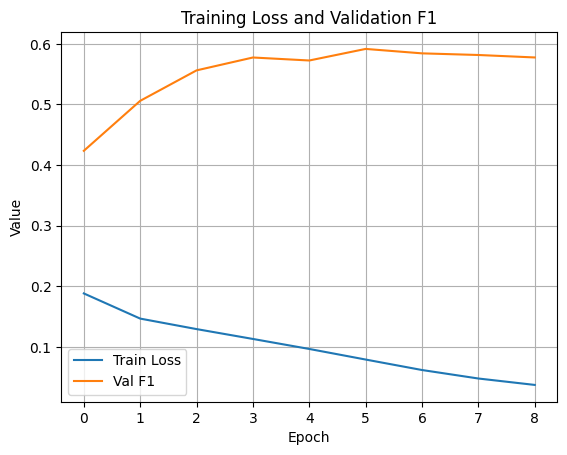

In [ ]:
# Training loop with EarlyStopping and best threshold search
train_losses, val_f1s = [], []
best_val_f1 = 0
epochs_no_improve = 0
best_model_state = None

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for inputs, labels in loop:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    best_th, val_f1 = find_best_threshold(model, val_loader)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Best Threshold={best_th:.2f}, Val F1={val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break


In [ ]:
# Save model to Google Drive
torch.save(best_model_state, "/content/drive/MyDrive/Recognizing_Organelle/resnet50_pretrained_model.pth")
print("Saved best model to Google Drive: resnet50_best_model.pth")

# Plot and save training curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Validation F1")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/MyDrive/Recognizing_Organelle/loss_f1_curve.png")
plt.show()

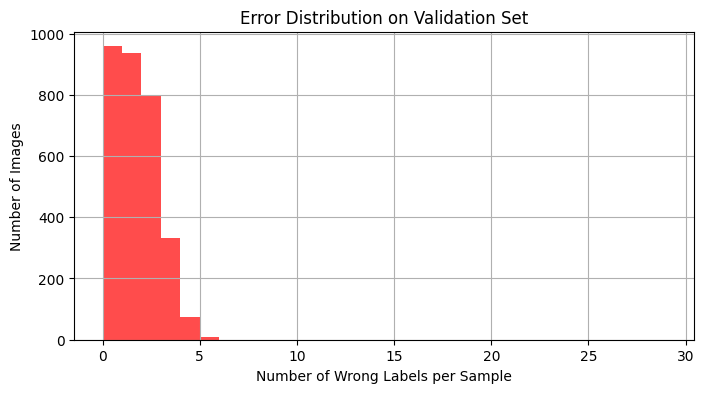

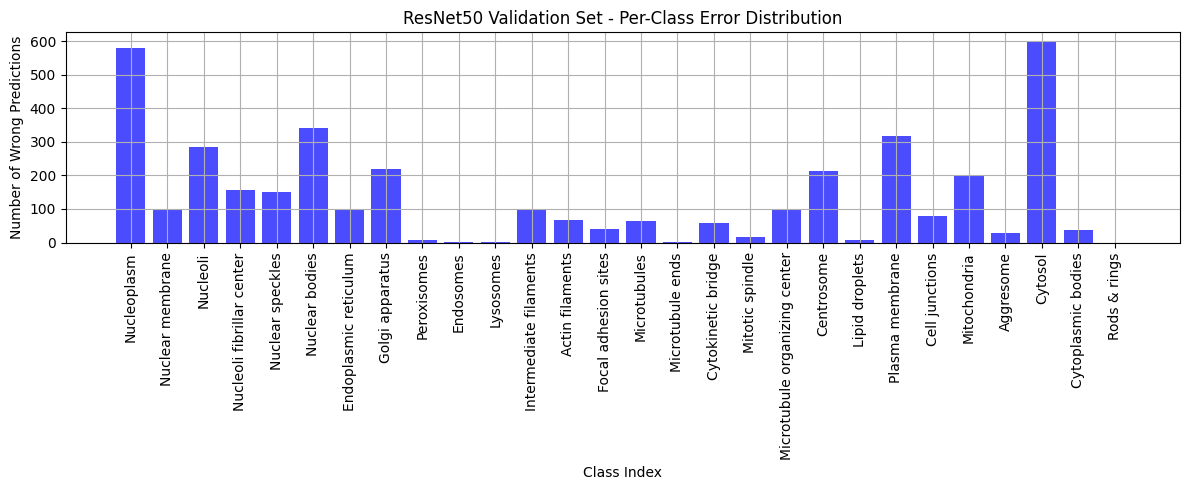

📊 Validation F1 Score: 0.5516
📊 Validation Accuracy: 0.3083


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import f1_score
import numpy as np

# Load Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build model
model = models.resnet50(weights=None)
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 28)
)
model.load_state_dict(torch.load("/content/drive/MyDrive/Recognizing_Organelle/Models/resnet50_pretrained_model.pth", map_location=device))
model.to(device)
model.eval()

# Evaluate on Validation Set
BATCH_SIZE = 64
criterion = nn.BCEWithLogitsLoss()

val_dataset = torch.utils.data.TensorDataset(val_input, val_target)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_errors = []  # Track errors per image
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5

        # Calculate error per image (Hamming distance)
        errors = (preds.int() != labels.int()).sum(dim=1).cpu().numpy()
        all_errors.extend(errors)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate full predictions and labels
all_preds = torch.cat(all_preds).int().numpy()
all_labels = torch.cat(all_labels).int().numpy()

# Plot Error Distribution (per sample)
plt.figure(figsize=(8,4))
plt.hist(all_errors, bins=range(0, 30), color='red', alpha=0.7)
plt.xlabel('Number of Wrong Labels per Sample')
plt.ylabel('Number of Images')
plt.title('Error Distribution on Validation Set')
plt.grid(True)
plt.show()

# Plot Error Distribution (per class)


per_class_errors = np.abs(all_preds - all_labels).sum(axis=0)

class_names = [
    'Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
    'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus',
    'Peroxisomes', 'Endosomes', 'Lysosomes', 'Intermediate filaments', 'Actin filaments',
    'Focal adhesion sites', 'Microtubules', 'Microtubule ends', 'Cytokinetic bridge',
    'Mitotic spindle', 'Microtubule organizing center', 'Centrosome', 'Lipid droplets',
    'Plasma membrane', 'Cell junctions', 'Mitochondria', 'Aggresome', 'Cytosol',
    'Cytoplasmic bodies', 'Rods & rings'
]

plt.figure(figsize=(12,5))
plt.bar(range(28), per_class_errors, color='blue', alpha=0.7)
plt.xlabel('Class Index')
plt.ylabel('Number of Wrong Predictions')
plt.title('ResNet50 Validation Set - Per-Class Error Distribution')
plt.xticks(ticks=range(28), labels=class_names, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Compute F1 score
f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
print(f" Validation F1 Score: {f1:.4f}")

# Optional: compute accuracy
acc = accuracy_score(all_labels, all_preds)
print(f" Validation Accuracy: {acc:.4f}")




## Resnet18 Without Parameters


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Hyperparameters
BATCH_SIZE = 64
NUM_CLASSES = 28
EPOCHS = 30
LR = 1e-4
VAL_RATIO = 0.1
PATIENCE = 3
THRESHOLDS = np.linspace(0.05, 0.95, 19)

# Paths
INPUT_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input.pt"
TARGET_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_target.pt"
SAVE_DIR = "/content/drive/MyDrive/Recognizing_Organelle/Models"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load full tensors
input_tensor = torch.load(INPUT_PATH)
target_tensor = torch.load(TARGET_PATH)

# Split dataset
total_len = input_tensor.shape[0]
val_len = int(total_len * VAL_RATIO)
train_input = input_tensor[:total_len - val_len]
train_target = target_tensor[:total_len - val_len]
val_input = input_tensor[total_len - val_len:]
val_target = target_tensor[total_len - val_len:]


In [ ]:
class TensorDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = TensorDataset(train_input, train_target)
val_dataset = TensorDataset(val_input, val_target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [ ]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18 (without pretrained weights)
model = models.resnet18(weights=None)
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
def evaluate_f1(model, loader, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).int()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return f1_score(all_labels, all_preds, average='samples', zero_division=0)

def find_best_threshold(model, loader):
    best_f1, best_th = 0.0, 0.5
    for th in THRESHOLDS:
        f1 = evaluate_f1(model, loader, threshold=th)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
    return best_th, best_f1


In [ ]:
train_losses, val_f1s = [], []
best_val_f1 = 0
best_model_state = None
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    best_th, val_f1 = find_best_threshold(model, val_loader)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Best Th={best_th:.2f}, Val F1={val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"⏹Early stopping at epoch {epoch+1}")
            break


Epoch 1/30: 100%|██████████| 437/437 [00:22<00:00, 19.08it/s, loss=0.14]


Epoch 1: Loss=0.1378, Best Th=0.20, Val F1=0.4414


Epoch 2/30: 100%|██████████| 437/437 [00:22<00:00, 19.09it/s, loss=0.135]


Epoch 2: Loss=0.1313, Best Th=0.20, Val F1=0.5231


Epoch 3/30: 100%|██████████| 437/437 [00:22<00:00, 19.05it/s, loss=0.119]


Epoch 3: Loss=0.1246, Best Th=0.15, Val F1=0.4700


Epoch 4/30: 100%|██████████| 437/437 [00:23<00:00, 18.96it/s, loss=0.118]


Epoch 4: Loss=0.1187, Best Th=0.25, Val F1=0.5499


Epoch 5/30: 100%|██████████| 437/437 [00:22<00:00, 19.02it/s, loss=0.146]


Epoch 5: Loss=0.1143, Best Th=0.25, Val F1=0.5524


Epoch 6/30: 100%|██████████| 437/437 [00:22<00:00, 19.04it/s, loss=0.0954]


Epoch 6: Loss=0.1091, Best Th=0.20, Val F1=0.5448


Epoch 7/30: 100%|██████████| 437/437 [00:22<00:00, 19.06it/s, loss=0.0838]


Epoch 7: Loss=0.1038, Best Th=0.20, Val F1=0.5654


Epoch 8/30: 100%|██████████| 437/437 [00:22<00:00, 19.08it/s, loss=0.0856]


Epoch 8: Loss=0.0961, Best Th=0.20, Val F1=0.5574


Epoch 9/30: 100%|██████████| 437/437 [00:23<00:00, 18.97it/s, loss=0.0793]


Epoch 9: Loss=0.0852, Best Th=0.25, Val F1=0.5362


Epoch 10/30: 100%|██████████| 437/437 [00:22<00:00, 19.02it/s, loss=0.0766]


Epoch 10: Loss=0.0714, Best Th=0.25, Val F1=0.5487
⏹Early stopping at epoch 10


Best model saved to /content/drive/MyDrive/Recognizing_Organelle/Models/resnet18_model.pth


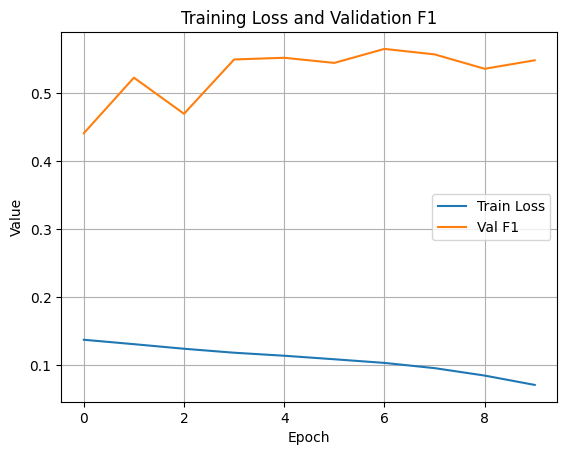

In [ ]:
# Save best model
save_path = os.path.join(SAVE_DIR, "/content/drive/MyDrive/Recognizing_Organelle/Models/resnet18_model.pth")
torch.save(best_model_state, save_path)
print(f"Best model saved to {save_path}")

# Plot Loss / F1 curve
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_f1s, label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Validation F1")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "/content/drive/MyDrive/Recognizing_Organelle/Models/resnet18_model_loss_f1_curve.png"))
plt.show()


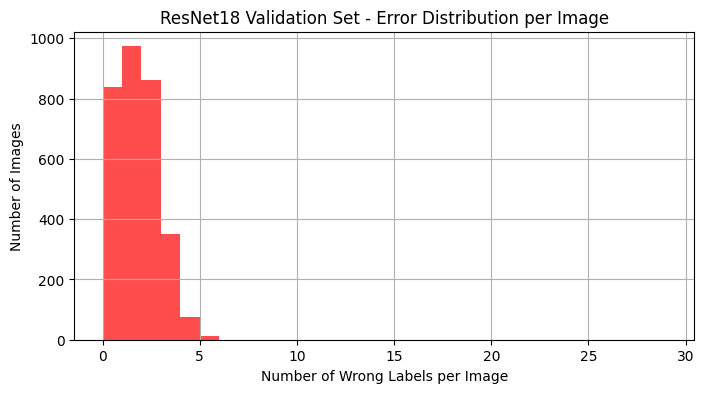

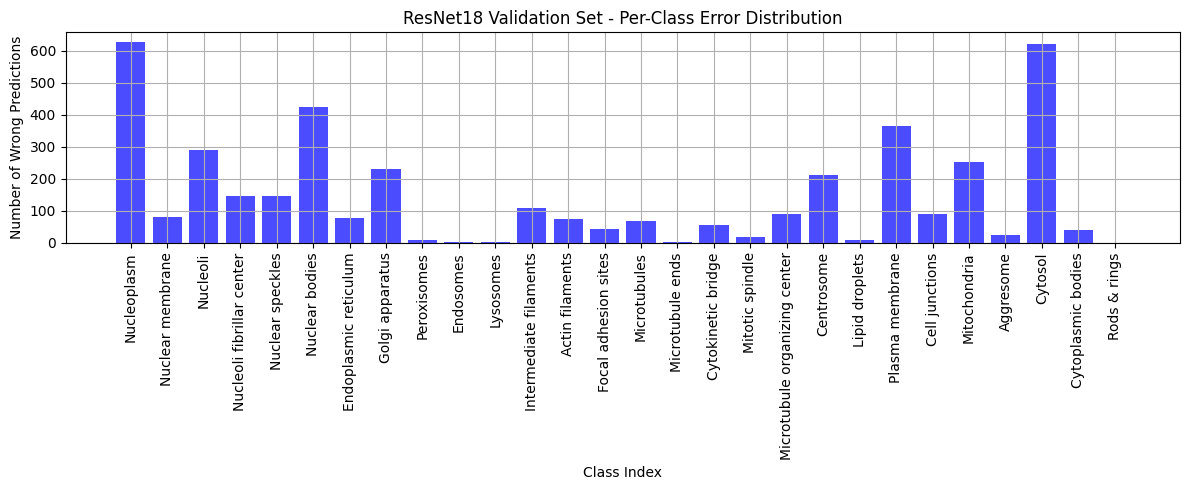

📊 ResNet18 Validation F1 Score: 0.5117
📊 Validation Accuracy: 0.2697


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import f1_score
import numpy as np

# ✅ Load ResNet18 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=None)
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
# Modify the fc layer to match the likely saved model structure
model.fc = nn.Linear(model.fc.in_features, 28)


model.load_state_dict(torch.load("/content/drive/MyDrive/Recognizing_Organelle/Models/resnet18_model.pth", map_location=device))
model.to(device)
model.eval()

# Evaluate on Validation Set
BATCH_SIZE = 64
criterion = nn.BCEWithLogitsLoss()

val_dataset = torch.utils.data.TensorDataset(val_input, val_target)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_errors = []
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5

        errors = (preds.int() != labels.int()).sum(dim=1).cpu().numpy()
        all_errors.extend(errors)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).int().numpy()
all_labels = torch.cat(all_labels).int().numpy()

# Plot Error Distribution (per sample)
plt.figure(figsize=(8,4))
plt.hist(all_errors, bins=range(0, 30), color='red', alpha=0.7)
plt.xlabel('Number of Wrong Labels per Image')
plt.ylabel('Number of Images')
plt.title('ResNet18 Validation Set - Error Distribution per Image')
plt.grid(True)
plt.show()

# Plot Error Distribution (per class)
per_class_errors = np.abs(all_preds - all_labels).sum(axis=0)

class_names = [
    'Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
    'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus',
    'Peroxisomes', 'Endosomes', 'Lysosomes', 'Intermediate filaments', 'Actin filaments',
    'Focal adhesion sites', 'Microtubules', 'Microtubule ends', 'Cytokinetic bridge',
    'Mitotic spindle', 'Microtubule organizing center', 'Centrosome', 'Lipid droplets',
    'Plasma membrane', 'Cell junctions', 'Mitochondria', 'Aggresome', 'Cytosol',
    'Cytoplasmic bodies', 'Rods & rings'
]

plt.figure(figsize=(12,5))
plt.bar(range(28), per_class_errors, color='blue', alpha=0.7)
plt.xlabel('Class Index')
plt.ylabel('Number of Wrong Predictions')
plt.title('ResNet18 Validation Set - Per-Class Error Distribution')
plt.xticks(ticks=range(28), labels=class_names, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# F1 Score
f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
print(f"📊 ResNet18 Validation F1 Score: {f1:.4f}")
acc = accuracy_score(all_labels, all_preds)
print(f"📊 Validation Accuracy: {acc:.4f}")

###code

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os

class PTTrainDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.image_ids = sorted([f[:-3] for f in os.listdir(input_dir) if f.endswith('.pt')])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = torch.load(os.path.join(self.input_dir, f"{image_id}.pt"))
        label = torch.load(os.path.join(self.target_dir, f"{image_id}.pt")).float()
        return image, label

input_dir = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input"
target_dir = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_target"
train_dataset = PTTrainDataset(input_dir, target_dir)
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)


In [ ]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 28

model = models.resnet18(weights="DEFAULT")
model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model = model.to(device)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        progress_bar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"✅ Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")


Epoch 1/10: 100%|██████████| 103/103 [00:46<00:00,  2.22it/s, loss=0.179]


✅ Epoch [1/10] Loss: 0.2572


Epoch 2/10: 100%|██████████| 103/103 [00:41<00:00,  2.47it/s, loss=0.154]


✅ Epoch [2/10] Loss: 0.1646


Epoch 3/10: 100%|██████████| 103/103 [00:43<00:00,  2.37it/s, loss=0.194]


✅ Epoch [3/10] Loss: 0.1537


Epoch 4/10: 100%|██████████| 103/103 [00:43<00:00,  2.35it/s, loss=0.143]


✅ Epoch [4/10] Loss: 0.1390


Epoch 5/10: 100%|██████████| 103/103 [00:42<00:00,  2.44it/s, loss=0.1]


✅ Epoch [5/10] Loss: 0.1214


Epoch 6/10: 100%|██████████| 103/103 [00:42<00:00,  2.40it/s, loss=0.0869]


✅ Epoch [6/10] Loss: 0.1002


Epoch 7/10: 100%|██████████| 103/103 [00:42<00:00,  2.45it/s, loss=0.068]


✅ Epoch [7/10] Loss: 0.0775


Epoch 8/10: 100%|██████████| 103/103 [00:43<00:00,  2.37it/s, loss=0.0669]


✅ Epoch [8/10] Loss: 0.0571


Epoch 9/10: 100%|██████████| 103/103 [00:39<00:00,  2.60it/s, loss=0.0396]


✅ Epoch [9/10] Loss: 0.0421


Epoch 10/10: 100%|██████████| 103/103 [00:30<00:00,  3.39it/s, loss=0.037]

✅ Epoch [10/10] Loss: 0.0312


In [ ]:

model_save_dir = "/content/drive/MyDrive/Recognizing_Organelle/Models"


os.makedirs(model_save_dir, exist_ok=True)

model_save_path = os.path.join(model_save_dir, "resnet50_pretrained_multilabel.pth")

torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/MyDrive/Recognizing_Organelle/Models/resnet50_pretrained_multilabel.pth


## KNN


In [ ]:
#KNN
import torch
from torchvision import models

# Load ResNet18 feature extractor (remove classification head)
def build_resnet18_feature_extractor(in_channels=4):
    model = models.resnet18(weights=None)
    model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = torch.nn.Identity()  # Remove the final classification layer
    return model

# Load your trained model and remove FC for feature extraction
model = build_resnet18_feature_extractor()
model.load_state_dict(torch.load("/content/drive/MyDrive/Recognizing_Organelle/Models/resnet18_model.pth", map_location="cpu"), strict=False)
model.eval()


ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import numpy as np
from torch.utils.data import DataLoader

# Assuming you have train_loader or similar prepared
all_features = []
all_labels = []

# Load input and target tensors
INPUT_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_input.pt"
TARGET_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Data/train_tensors_target.pt"

class TensorDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

input_tensor = torch.load(INPUT_PATH)
target_tensor = torch.load(TARGET_PATH)


In [ ]:
train_dataset = TensorDataset(input_tensor, target_tensor)

# Hyperparameters
BATCH_SIZE = 64
NUM_CLASSES = 28
EPOCHS = 30
LR = 1e-4
VAL_RATIO = 0.1
PATIENCE = 3  # EarlyStopping patience
THRESHOLDS = np.linspace(0.05, 0.95, 19)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)



with torch.no_grad():
    for inputs, labels in train_loader:
        features = model(inputs).cpu().numpy()  # shape: [batch_size, 512]
        all_features.append(features)
        all_labels.append(labels.numpy())

X_train = np.concatenate(all_features, axis=0)
y_train = np.concatenate(all_labels, axis=0)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN on extracted features
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

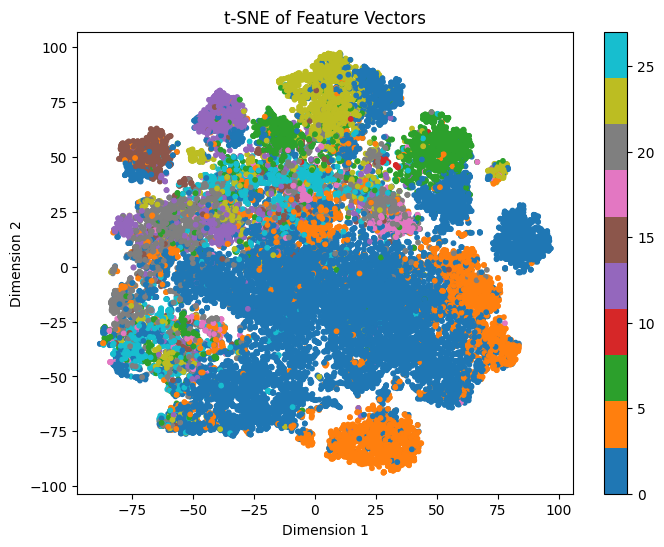

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train.argmax(axis=1), cmap='tab10', s=10)
plt.colorbar()
plt.title('t-SNE of Feature Vectors')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [ ]:
import joblib

joblib.dump(knn, "/content/drive/MyDrive/Recognizing_Organelle/Models/knn_model.pkl")

['/content/drive/MyDrive/Recognizing_Organelle/Models/knn_model.pkl']

In [ ]:
import torch
import joblib
import pandas as pd
from tqdm import tqdm

# Paths
TEST_INPUT_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Data/test_tensors_input.pt"
KNN_MODEL_PATH = "/content/drive/MyDrive/Recognizing_Organelle/Models/knn_model.pkl"
SAVE_CSV_PATH = "/content/drive/MyDrive/Recognizing_Organelle/knn_submission.csv"

# Load test data
test_tensor = torch.load(TEST_INPUT_PATH)  # Shape: [N_test, 4, H, W]

# Load trained KNN model
from sklearn.neighbors import KNeighborsClassifier
knn = joblib.load(KNN_MODEL_PATH)
print(" KNN model loaded.")

# Load feature extractor (ResNet18 without classifier)
from torchvision import models
import torch.nn as nn

def build_resnet18_feature_extractor():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Identity()
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = build_resnet18_feature_extractor()
feature_extractor.load_state_dict(torch.load("/content/drive/MyDrive/Recognizing_Organelle/Models/resnet18_model.pth", map_location=device), strict=False)
feature_extractor.to(device)
feature_extractor.eval()

# Extract features from test images
all_test_features = []

with torch.no_grad():
    for i in tqdm(range(0, len(test_tensor), 64), desc="🔍 Extracting Features"):
        batch = test_tensor[i:i+64].to(device)
        features = feature_extractor(batch).cpu().numpy()  # Shape: [batch_size, 512]
        all_test_features.append(features)

X_test = np.concatenate(all_test_features, axis=0)  # Shape: [N_test, 512]

print(f"✅ Extracted features: {X_test.shape}")

# Predict with KNN
y_pred = knn.predict(X_test)  # Shape: [N_test, NUM_CLASSES] (multi-label or multi-class)

# Save to CSV (assuming multi-label, where y_pred is binary 0/1 per label)
results = []
for idx, row in enumerate(y_pred):
    label_indices = [str(i) for i, val in enumerate(row) if val == 1]
    label_str = " ".join(label_indices)
    results.append({"Id": str(idx), "Predicted": label_str})

df = pd.DataFrame(results)
df.to_csv(SAVE_CSV_PATH, index=False)
print(f"CSV saved: {SAVE_CSV_PATH}")


✅ KNN model loaded.


🔍 Extracting Features: 100%|██████████| 183/183 [00:04<00:00, 42.69it/s]


✅ Extracted features: (11702, 512)
✅ CSV saved: /content/drive/MyDrive/Recognizing_Organelle/knn_submission.csv


Evaluating KNN using only F1 Score (Multilabel):

Testing k = 3
k = 3: F1 Score = 0.6787

Testing k = 5
k = 5: F1 Score = 0.6272

Testing k = 7
k = 7: F1 Score = 0.6008

Testing k = 9
k = 9: F1 Score = 0.5885

Testing k = 11
k = 11: F1 Score = 0.5818

Best k: 3 (F1 Score = 0.6787)


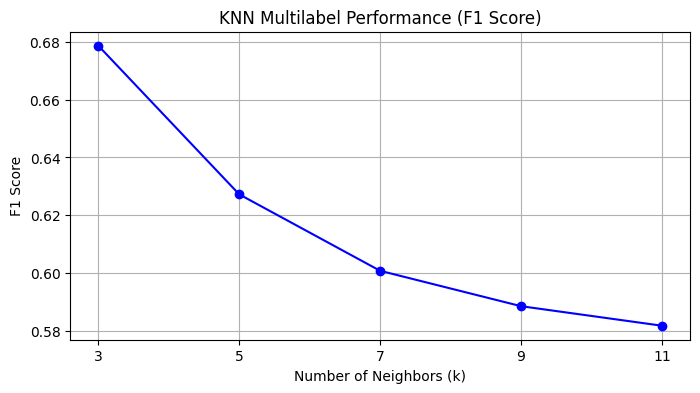

In [ ]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

Ks = [3, 5, 7, 9, 11]
f1_scores = []

print("Evaluating KNN using only F1 Score (Multilabel):")

for k in Ks:
    print(f"\nTesting k = {k}")
    knn_val = KNeighborsClassifier(n_neighbors=k)
    knn_val.fit(X_train, y_train)

    y_pred_val = knn_val.predict(X_val)

    f1_val = f1_score(y_val, y_pred_val, average='samples', zero_division=0)
    f1_scores.append(f1_val)

    print(f"k = {k}: F1 Score = {f1_val:.4f}")

best_f1_index = np.argmax(f1_scores)
best_k = Ks[best_f1_index]
best_f1 = f1_scores[best_f1_index]

print(f"\nBest k: {best_k} (F1 Score = {best_f1:.4f})")


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(Ks, f1_scores, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('KNN Multilabel Performance (F1 Score)')
plt.xticks(Ks)
plt.grid(True)
plt.show()



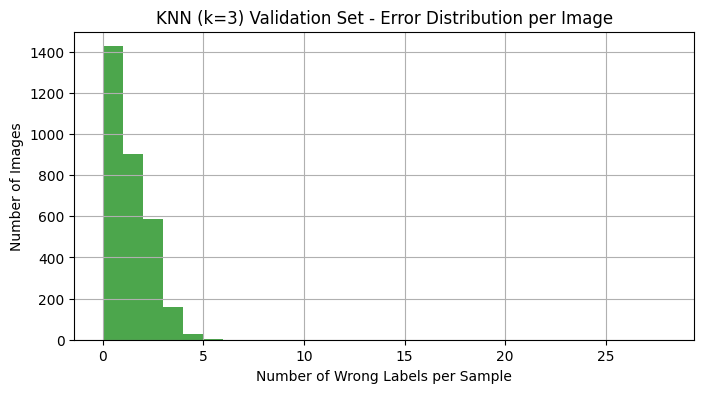

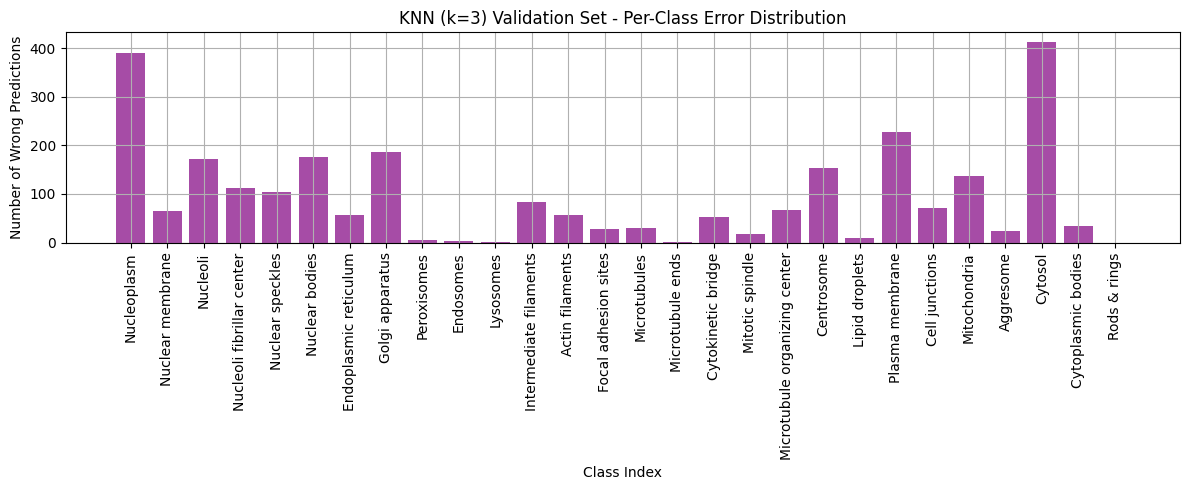

📊 KNN (k=3) Validation F1 Score: 0.6787
📊 KNN (k=3) Validation Accuracy: 0.4593


In [ ]:
# prompt: for knn k=3, do the same error distrubution plots as resnet 18 and 50

import matplotlib.pyplot as plt
import numpy as np
# Re-evaluate KNN with the best k (assuming k=3 is the best based on the existing code)
# Evaluate KNN on the validation set to get predictions for error analysis
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train) # Retrain KNN on the full training features

# Evaluate on Validation Set to get predictions for error analysis
y_pred_val_knn = knn.predict(X_val) # Use X_val and y_val from the k-tuning section

# Plot Error Distribution (per sample) for KNN (k=3)
all_errors_knn = (y_pred_val_knn != y_val.astype(int)).sum(axis=1) # Calculate errors

plt.figure(figsize=(8,4))
plt.hist(all_errors_knn, bins=range(0, y_val.shape[1] + 1), color='green', alpha=0.7)
plt.xlabel('Number of Wrong Labels per Sample')
plt.ylabel('Number of Images')
plt.title('KNN (k=3) Validation Set - Error Distribution per Image')
plt.grid(True)
plt.show()

# Plot Error Distribution (per class) for KNN (k=3)
per_class_errors_knn = np.abs(y_pred_val_knn - y_val.astype(int)).sum(axis=0)

class_names = [
    'Nucleoplasm', 'Nuclear membrane', 'Nucleoli', 'Nucleoli fibrillar center',
    'Nuclear speckles', 'Nuclear bodies', 'Endoplasmic reticulum', 'Golgi apparatus',
    'Peroxisomes', 'Endosomes', 'Lysosomes', 'Intermediate filaments', 'Actin filaments',
    'Focal adhesion sites', 'Microtubules', 'Microtubule ends', 'Cytokinetic bridge',
    'Mitotic spindle', 'Microtubule organizing center', 'Centrosome', 'Lipid droplets',
    'Plasma membrane', 'Cell junctions', 'Mitochondria', 'Aggresome', 'Cytosol',
    'Cytoplasmic bodies', 'Rods & rings'
]

plt.figure(figsize=(12,5))
plt.bar(range(len(class_names)), per_class_errors_knn, color='purple', alpha=0.7)
plt.xlabel('Class Index')
plt.ylabel('Number of Wrong Predictions')
plt.title('KNN (k=3) Validation Set - Per-Class Error Distribution')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# F1 Score and Accuracy for k=3 KNN on validation set
f1_knn = f1_score(y_val, y_pred_val_knn, average='samples', zero_division=0)
acc_knn = accuracy_score(y_val, y_pred_val_knn)
print(f"KNN (k=3) Validation F1 Score: {f1_knn:.4f}")
print(f"KNN (k=3) Validation Accuracy: {acc_knn:.4f}")
